In [114]:
from herbie import Herbie
from herbie import FastHerbie
import pandas as pd
import pickle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from paint.standard2 import cm_tmp, cm_wind, cm_wave_height, cm_pcp
from toolbox import EasyMap, pc, ccrs
import xarray as xr
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import pvlib

import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature

Let's load our earlier profiles:
- day-ahead forecasted power based on the coarsened HRRR
- forecasted power based on max and min from the coarsened HRRR
- normalized "max-min" range
- weighted average TCC from GEFS
- modeled actual power (from HRRR)
- modeled clear sky power

In [115]:
p_ac_hrrr_coarse_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_all.pkl')
p_ac_hrrr_coarse_max_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_max_all.pkl')
p_ac_hrrr_coarse_min_all = pd.read_pickle('example_data/p_ac_hrrr_coarse_min_all.pkl')
max_min_norm = pd.read_pickle('example_data/max_min_norm_20210408.pkl')
weighted_avg_tcc = pd.read_pickle('example_data/weighted_avg_tcc_20210408.pkl')

power_ac_cs_all = pd.read_pickle('example_data/power_ac_cs_all.pkl')
p_ac_hrrr_actuals_all = pd.read_pickle('example_data/p_ac_hrrr_actuals_all.pkl')

As a reminder, here's a plot of actual and forecasted power, along with clear sky and the max-min range for reference:

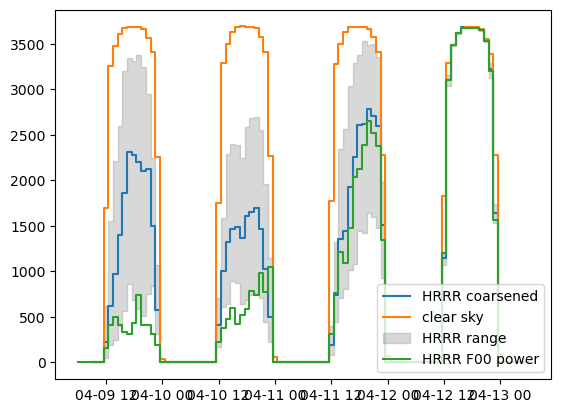

In [116]:
mask = (power_ac_cs_all.index >= p_ac_hrrr_coarse_all.index[0]) & (power_ac_cs_all.index <= p_ac_hrrr_coarse_all.index[-1])

plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power')
plt.legend(loc='lower right')
plt.show()

Now, let's look at actuals and forecasts with the two uncertainty indicators we developed earlier:
1. the standard deviation of weighted average TCC from GEFS
2. range of max and min power from HRRR, normalized to clear sky power

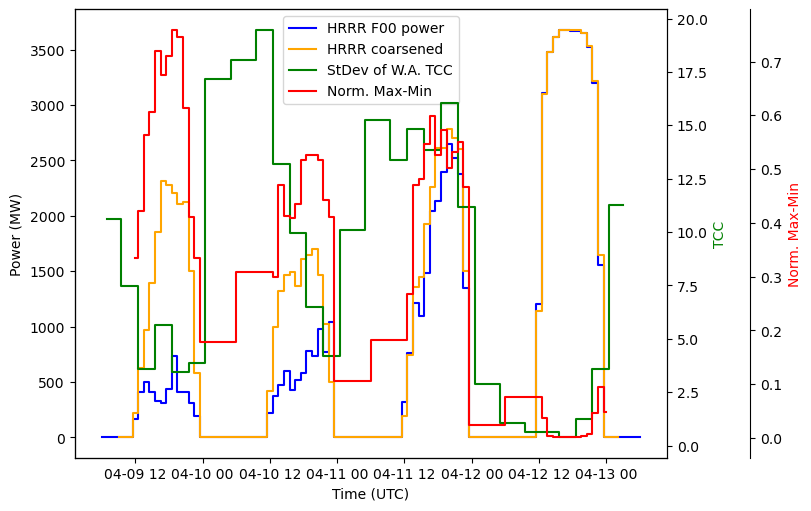

In [117]:
# Based on https://stackoverflow.com/a/45925049
# More versatile wrapper
fig, ax1 = plt.subplots(figsize=(8,5), layout='constrained') # (width, height) in inches

ax2 = ax1.twinx()
ax3 = ax1.twinx()
    
ax1.set_xlabel("Time (UTC)")
ax1.set_ylabel("Power (MW)")
ax2.set_ylabel("TCC")
ax3.set_ylabel("Norm. Max-Min")

p1 = ax1.plot(p_ac_hrrr_actuals_all.index, 
         p_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power',
         color='blue',
         )

p2 = ax1.plot(p_ac_hrrr_coarse_all.index,
              p_ac_hrrr_coarse_all.power_ac,
              drawstyle='steps-mid',
              label='HRRR coarsened',
              color='orange',
              )

p3 = ax2.plot(weighted_avg_tcc.index, weighted_avg_tcc.tcc_std, drawstyle='steps-mid',
         label='StDev of W.A. TCC', color='green')

p4 = ax3.plot(max_min_norm.index, max_min_norm.max_min_norm, drawstyle='steps-mid',
         label='Norm. Max-Min', color='red')

ax1.legend(handles=p1+p2+p3+p4, loc='upper center')

# right, left, top, bottom
ax3.spines['right'].set_position(('outward', 60))

ax2.yaxis.label.set_color(p3[0].get_color())
ax3.yaxis.label.set_color(p4[0].get_color())

The chart is a bit busy, but if we compare the first three days with the last one, we can see that there is a very loose correlation between forecast error and our two uncertainty indicators. 

TO-DO:
- [**DONE**] merge datasets on time index
- filter periods with low power (`power_ac_cs_all < = power_ac_cs_all.power_ac.max()*0.001` maybe?)
- [**DONE**] calculate abs error, normalized abs error
- [**DONE**] scatter plots of normalized abs error vs std of wa tcc, norm. min-mx

Rename the `power_ac` column in all the power dataframes:

In [118]:
p_ac_hrrr_coarse_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_all'}, inplace=True)
p_ac_hrrr_coarse_max_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_max_all'}, inplace=True)
p_ac_hrrr_coarse_min_all.rename(columns={'power_ac': 'p_ac_hrrr_coarse_min_all'}, inplace=True)
power_ac_cs_all.rename(columns={'power_ac': 'power_ac_cs_all'}, inplace=True)
p_ac_hrrr_actuals_all.rename(columns={'power_ac': 'p_ac_hrrr_actuals_all'}, inplace=True)

In [119]:
# localize (assigne timezone of UTC)
weighted_avg_tcc = weighted_avg_tcc.copy().tz_localize('UTC')

# list of dataframes to combiner first
dfs = [
    p_ac_hrrr_coarse_all,
    p_ac_hrrr_coarse_max_all,
    p_ac_hrrr_coarse_min_all,
    power_ac_cs_all,
    p_ac_hrrr_actuals_all,
    weighted_avg_tcc.tcc_std,
    ]

# combine all dataframes and drop na rows
df = pd.concat(dfs, axis=1).dropna()

# add max_min_norm
df = df.merge(max_min_norm, how='outer', left_index=True, right_index=True)

,p_ac_hrrr_coarse_all,p_ac_hrrr_coarse_max_all,p_ac_hrrr_coarse_min_all,power_ac_cs_all,p_ac_hrrr_actuals_all,tcc_std,max_min_norm
2021-04-09 09:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,10.594097,NaN
2021-04-09 10:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,7.452738,NaN
2021-04-09 11:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,7.452738,NaN
2021-04-09 12:00:00+00:00,222.706277,617.615435,47.831043,1697.623971,164.160583,7.452738,0.335636
2021-04-09 13:00:00+00:00,624.550569,1558.007748,186.526180,3255.001441,408.724430,3.571200,0.421346
...,...,...,...,...,...,...,...
2021-04-12 22:00:00+00:00,3219.858786,3284.373583,3127.284784,3392.087914,3198.260498,3.572638,0.046310
2021-04-12 23:00:00+00:00,1646.764341,1742.823825,1527.959742,2276.877475,1559.932499,3.572638,0.094368
2021-04-13 00:00:00+00:00,6.886596,8.755479,4.276920,94.067422,5.197612,3.572638,0.047610
2021-04-13 01:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,11.260237,NaN


In [124]:
df['abs_err'] = (df.p_ac_hrrr_coarse_all - df.p_ac_hrrr_actuals_all).abs()
df['norm_abs_err'] = df.abs_err/power_ac_cs_all.power_ac_cs_all.max() # use power_ac_cs_all.max() as proxy for nameplate rating

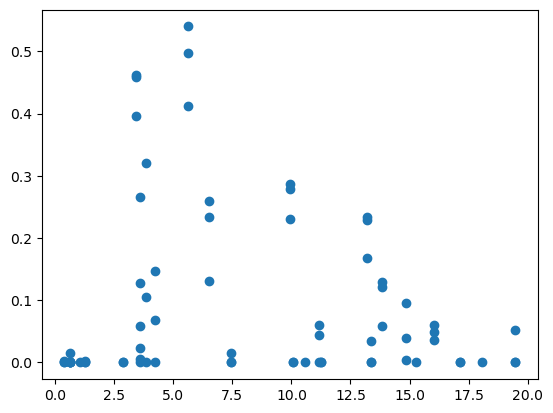

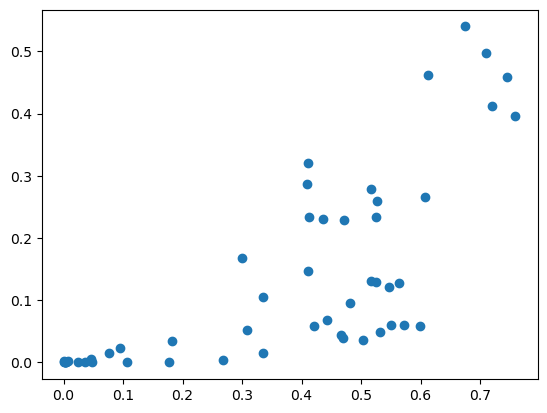

In [127]:
plt.scatter(df.tcc_std, df.norm_abs_err)
plt.show()

plt.scatter(df.max_min_norm, df.norm_abs_err)
plt.show()